# Exploration 

In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data loading

In [2]:
# Assumes download_and_extract_data.sh has already been run


PROJECT_PATH = os.path.abspath("")
DATA_PATH = os.path.join(PROJECT_PATH, "storage", "data")

In [3]:
def read_gesture_data(path: str) -> pd.DataFrame:
    gesture = pd.DataFrame()
    
    if "Template_Acceleration" in str(path):
        gesture =  pd.read_csv(
            path, 
            names=["x", "y", "z"], 
            header=None, 
            sep=" "
        )
    return gesture

In [4]:
file_list = list(Path(DATA_PATH).rglob("*.txt"))

#### Number of timesteps in each gesture

In [5]:
max_len = 0
series_lengths = []

for file_path in file_list:
    gesture = read_gesture_data(file_path)

    series_length = len(gesture)

    if series_length == 0:
        continue
    
    if series_length > max_len:
        max_len = series_length

    series_lengths.append(series_length)

In [6]:
max_len

315

<Axes: >

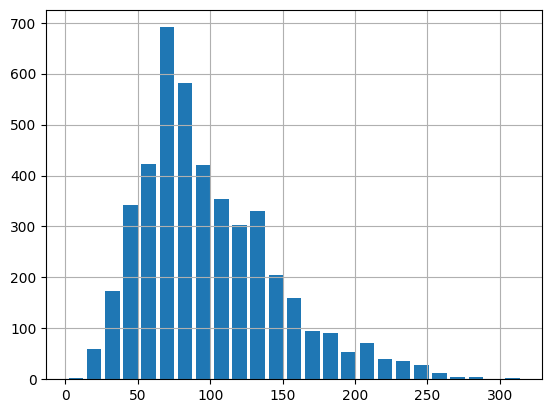

In [7]:
time_steps = pd.Series(series_lengths)
time_steps.hist(bins=25, rwidth=0.8)

In [8]:
time_steps.std() * 5

238.6569527976333

In [9]:
time_steps.quantile(0.99)

243.0

In [10]:
time_steps.quantile(0.005)

22.400000000000002

It might make sense to truncate the time-series to ~250 samples on the upper end and discard samples with less than ~25 samples for training

### Extracting sample and lable arrays 

In [11]:
data_samples = []
labels = pd.Series(dtype="string")

for file_index, file_path in enumerate(file_list):
    gesture = read_gesture_data(file_path)

    if len(gesture) == 0:
        continue

    
    data_samples.append(
         # To create an array, each sample should have the same dimension
         gesture.reindex(range(max_len), fill_value=np.nan).values
    )


    labels.loc[file_index] = str(file_path).split("Template_Acceleration")[1][0]

In [12]:
data_array = np.array(data_samples)
data_array.shape

(4481, 315, 3)

Dim: [N-samples, Time Steps, Dimensions]

## Class Distribution

In [13]:
labels.value_counts()

3    561
1    560
2    560
7    560
5    560
8    560
4    560
6    560
dtype: int64

<Axes: title={'center': 'Class Distribution'}>

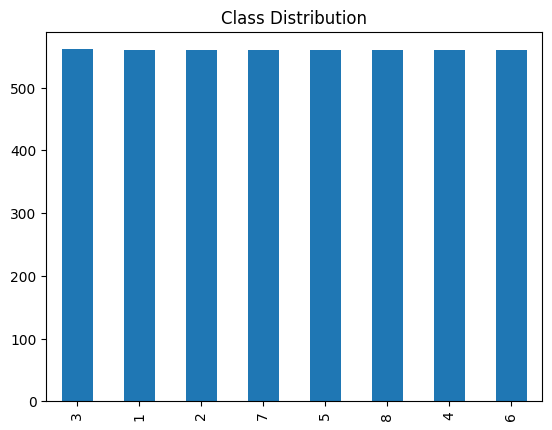

In [14]:
labels.value_counts().plot.bar(title="Class Distribution")

Almost perfect balance. No weighting, under or oversampling will be needed. 

## Number of timesteps as a potential feature

In [15]:
time_steps = pd.DataFrame(
    np.count_nonzero(~np.isnan(data_array), axis=1).max(axis=1), columns=["TimeSteps"]
)
time_steps.loc[:, "Labels"] = labels.values

<Axes: title={'center': 'Average steps for each gesture'}, xlabel='Labels'>

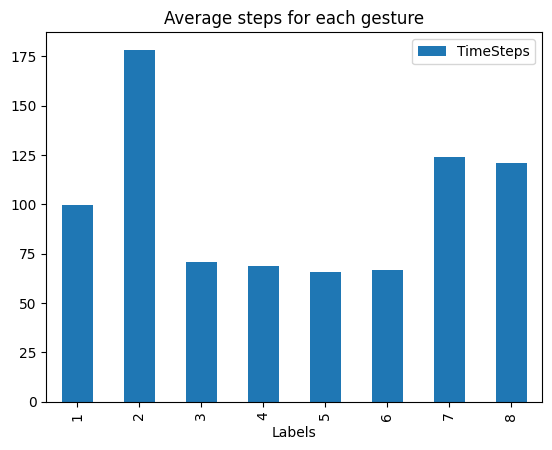

In [16]:
time_steps.groupby("Labels").mean().plot.bar(title="Average steps for each gesture")

It makes sense that the gestures 2, 7 and 8 have a longer duration on average as their paths are the longest, where as 3, 4, 5 and 6 have much shorter paths and are comparable. 1 lies in between.

This suggests that the number of time steps will also be a good predictor for a base-line model. 
For CNNs, the shorter time-series would have to be zero padded. 

## Exploring Mean and standard deviation of axis acceleration as potential features

In [17]:
dimension_mean = pd.DataFrame(np.nanmean(data_array, axis=1), columns=["x", "y", "z"])
dimension_mean.loc[:, "Label"] = labels.astype("float").values

dimension_deviation = pd.DataFrame(np.nanstd(data_array, axis=1), columns=["x", "y", "z"])
dimension_deviation.loc[:, "Label"] = labels.astype("float").values


#### Sample level

In [18]:
dim = "x"

Text(0.5, 1.0, 'x-axis mean vs. Labels \n ')

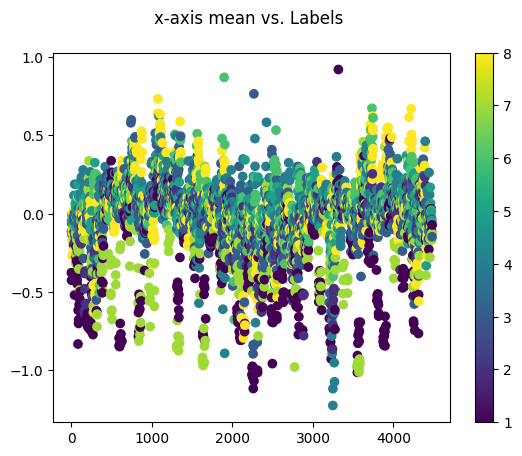

In [19]:
scatter = plt.scatter(
    dimension_mean.index, 
    dimension_mean[dim].values, 
    c=dimension_mean["Label"], 
)
plt.colorbar(scatter)

plt.title(f"{dim}-axis mean vs. Labels \n ")

Text(0.5, 1.0, 'x-axis Standard deviation vs. Labels \n ')

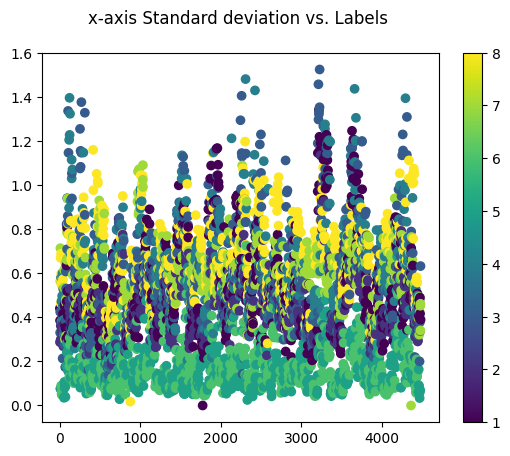

In [20]:
scatter = plt.scatter(
    dimension_deviation.index, 
    dimension_deviation[dim].values, 
    c=dimension_deviation["Label"], 
)
plt.colorbar(scatter)

plt.title(f"{dim}-axis Standard deviation vs. Labels \n ")

#### Overall

Text(0.5, 1.0, 'Overall Mean of Axes values (standardized) vs. Labels\n')

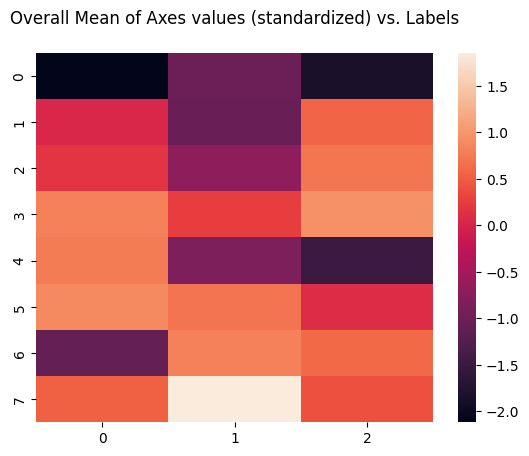

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

averages_by_class = dimension_mean.groupby("Label").mean()
averages_by_class = scaler.fit_transform(averages_by_class)
sns.heatmap(averages_by_class)
plt.title("Overall Mean of Axes values (standardized) vs. Labels\n")

Text(0.5, 1.0, 'Overall Standard deviation of Axes values (standardized) vs. Labels\n')

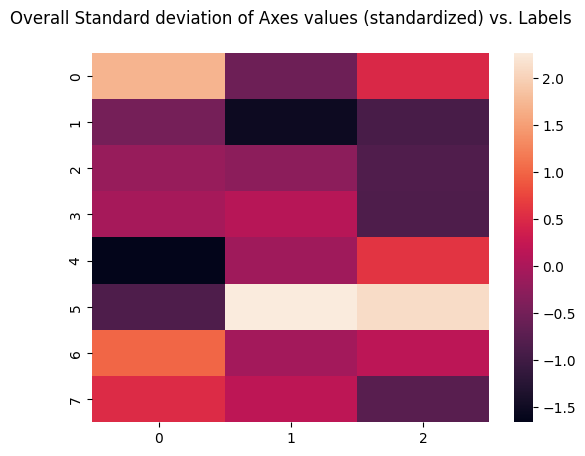

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

deviation_by_class = dimension_mean.groupby("Label").std()
deviation_by_class = scaler.fit_transform(deviation_by_class)
sns.heatmap(deviation_by_class)

plt.title("Overall Standard deviation of Axes values (standardized) vs. Labels\n")

## Conclusion

Even though it might seem like a naive approach, the previous heat map shows that the overall average and standard deviation of acceleration per-dimension should make for good features.

The number of time-steps in each acceleration-time-series also provides valuable distinction between the various gestures.

In addition, the class distribution is uniform, so any kind of balancing technique will not be required. 